In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math



Using TensorFlow backend.


In [2]:
#load data

train = pd.read_csv("sales_train_v2.csv")
test = pd.read_csv("test.csv")


In [3]:
#data preprocessing
print(train.shape)
#missing value
train.isnull().sum()

#duplicate value
train[train.duplicated(keep='first')].count()

(2935849, 6)


date              6
date_block_num    6
shop_id           6
item_id           6
item_price        6
item_cnt_day      6
dtype: int64

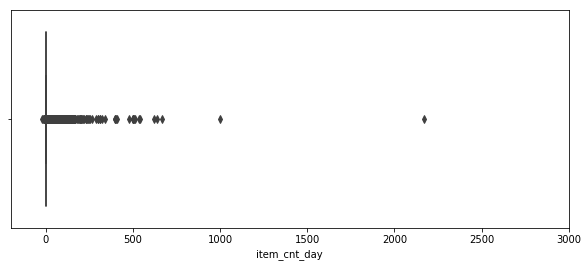

In [4]:
#Outliers
plt.figure(figsize=(10,4))
plt.xlim(-200, 3000)
sns.boxplot(x = train.item_cnt_day)

train = train.loc[(train.item_cnt_day < 2000)]
plt.show()

In [5]:

#transform the dataset in order to put in the model
train.date = train.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
train.date = train.date.apply(lambda x:dt.datetime.strftime(x,'%Y-%m'))
data = train.groupby(['date','item_id','shop_id']).sum().reset_index()

data = data[['date','item_id','shop_id','item_cnt_day']]
table = pd.pivot_table(data, values='item_cnt_day', index=['item_id', 'shop_id'],
                        columns=['date'], aggfunc=np.sum).reset_index()
table = table.fillna(0)

In [6]:
#get rid of those not in test data
data_inc = test.merge(table, on = ['item_id', 'shop_id'], how = 'left')
data_inc = data_inc.fillna(0)
data_inc = data_inc.iloc[:,3:]

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
look_back = 5 #change lookback here to test
def create_dataset(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data)-look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data[i + look_back])
    return np.array(dataX), np.array(dataY)

In [9]:
# data_inc.shape[0]

# normalize the dataset
norm = scaler.fit_transform(data_inc.values[374].reshape(-1,1)) #choose a random product
dataX, dataY = create_dataset(norm, look_back)

split = data_inc.shape[1] - look_back -1
X_train = dataX[:split]
X_test = dataX[split:]
Y_train = dataY[:split]
Y_test = dataY[split:]

In [10]:
#reshape to [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [11]:
def model_1(): #add lookback
    model = Sequential()
    model.add(LSTM(128, input_shape=(1,look_back)))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss='mse', optimizer=adam, metrics=['mean_squared_error'])

    # model.summary()

    return model

model1 = model_1()

W0823 18:17:45.305760  5192 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 18:17:45.420453  5192 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 18:17:45.470317  5192 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 18:17:45.795484  5192 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0823 18:17:45.804459  5192 deprecation.py:506

In [12]:
#record training time
start=time.time()
training1=model1.fit(X_train, Y_train, batch_size = 1, epochs = 20, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)


W0823 18:17:58.090217  5192 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0823 18:17:58.651712  5192 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/20
28/28 [==============================] - 2s 74ms/step - loss: 0.0881 - mean_squared_error: 0.0881 
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0640 - mean_squared_error: 0.0640
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0594 - mean_squared_error: 0.0594
Epoch 5/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0543 - mean_squared_error: 0.0543
Epoch 6/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0518 - mean_squared_error: 0.0518
Epoch 7/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 8/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0458 - mean_squared_error: 0.0458
Epoch 9/20
28/28 [==============================] - 0s 11ms/step - loss: 0.0422 - mean_squared_error: 0.0422
Epoch 10/20
28/28 [=====

In [13]:
# make predictions
trainPredict = model1.predict(X_train)
testPredict = model1.predict(X_test)

In [14]:

#test error
test_rmse = model1.evaluate(X_test, Y_test)
print("--------------------------")
print('RMSE' , test_rmse[0])

1/1 [==============================] - 0s 332ms/step
--------------------------
RMSE 0.6262652277946472


In [15]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(Y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(Y_test)

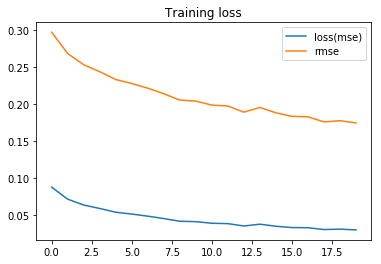

In [16]:
# print training loss
plt.plot(training1.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training1.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.legend(loc=1)
plt.show()


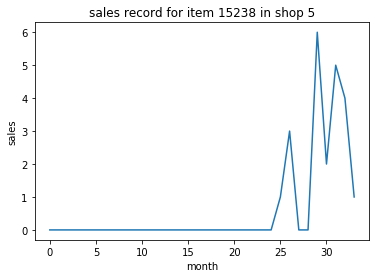

In [17]:
plt.plot(data_inc.values[374])
plt.xlabel('month')
plt.ylabel('sales')
plt.title('sales record for item 15238 in shop 5')

plt.show()